# Voltage stability impacts

#### the idea of this notebook is to estimate and visualize the impact of voltage stability on the precision of the final mass ratios at pentatrap. It is supposed to be a "why we need the junction source" summary, lets see...

### Outline: (is there data to suppport these claims?)

0. starep stability (allan, for different output voltages)
1. invariance theorem (needed ratio precision, axial precision(s))
2. red. cyclotron jitter (dependence on dU/U, evolution time/allan time)
3. dip smearing / not full down to noise floor dip (dependence on dip width? charge/mass?)
4. TBA 


## 0. Starep Stability

From Tests at Pentatrap (in the maglab, just comparing channels) it was found that the Starep has a static output noise, independent of the set output voltage.

At 3He Trap this was also tested, but there also with much smaller voltages. -> Results?

We can model the static absolute noise (like done in the PhaseJitter_PnA test script...):

In [2]:
from functools import partial
import numpy as np
from numpy.random import rand, exponential, normal
from matplotlib import pyplot as plt
import pandas as pd
import allantools as at

pi2 = 2*np.pi


In [3]:
## Helper functions for allan plots
def loglogfun(x, F0, x0, m):
    # a function linear in loglog defined by a point (x0, F0) and a slope m
    return F0 * (x/x0)**(m)

def create_loglog_function(x0, F0, x1, F1):
    # calcs the slope m for loglogfun
    m = np.log(F1/F0)/np.log(x1/x0)
    return partial(loglogfun, F0=F0, x0=x0, m=m)

def mergefun(x, fun1, fun2, offset):
    # adds two functions together and adds an offset.
    return fun1(x) + fun2(x) + offset

def createallan(s1p0, s1p1, s2p0, s2p1, offset):
    # creates allan-plot-ish function using two points for the white noise
    # linear slope in the beginning, two points for the brown noise in the end
    # and an offset value to flatten the middle if needed.
    # I use this to take the 4 points from a given allan plot where i dont have
    # the raw data from (or can find it ;) ) to create a look-up-table (function)
    # for stabilities after a specific time of averaging/sampling.
    func1 = create_loglog_function(s1p0[0], s1p0[1], s1p1[0], s1p1[1])
    func2 = create_loglog_function(s2p0[0], s2p0[1], s2p1[0], s2p1[1])
    full = partial(mergefun, fun1=func1, fun2=func2, offset=offset)
    return full

6.520577504029534e-07 7.172923094945629e-07
-9.028827588856285e-06 9.01677612293761e-06 0.00015007466144597675 3.001493228919535e-09


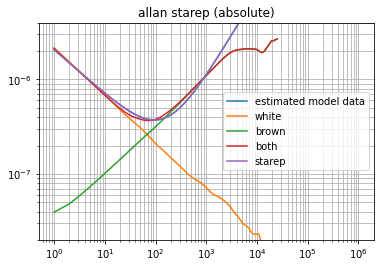

In [22]:
# starep
# it is originally 21 from the data, I adjusted it to 10 kind of arbitrary to get the observed phase
# jitter in axial phase measurements we experimentally observed.
data_scale = 10 #10 #21 #1 
# white noise\
s1p0 = (10, 7.0e-8*data_scale)
s1p1 = (33, 4.0e-8*data_scale)
# brown noise
s2p0 = (200, 2.5e-8*data_scale)
s2p1 = (1000, 1.05e-7*data_scale)
off = 0
starep = createallan(s1p0, s1p1, s2p0, s2p1, off)
x = np.linspace(1, 1000000, 1000000)
plt.loglog(x, starep(x), label="estimated model data")
#plt.grid(which="both")
#plt.xlim(5, 1e3)
##plt.ylim(4e-8*data_scale, 2e-7*data_scale)
#plt.title('allan starep (absolute)')
#plt.show()

# crosscheck
time_step = 1
rate = 1/time_step
data_size = 50000
white = starep(time_step)*normal(size=data_size)*1.05
print(starep(1)/np.sqrt(10), starep(10))
print(white.min(), white.max(), white.sum(), white.mean())
#plt.hist(white)
#plt.show()
#white += 21.1
#white /= 21.1
time = np.arange(0, time_step*data_size, time_step)
(t2, ad, ade, adn) = at.oadev(white, rate=rate, data_type="freq", taus=time)  # Compute the overlapping ADEV
plt.loglog(t2, ad, label='white')
brown = np.asarray([np.sum(white[:i])/np.sqrt(1500)*time_step for i in range(len(white))])#/30
#brown += 21.1
(t2, ad, ade, adn) = at.oadev(brown, rate=rate, data_type="freq", taus=time)  # Compute the overlapping ADEV
plt.loglog(t2, ad, label='brown')
(t2, ad, ade, adn) = at.oadev(brown+white, rate=rate, data_type="freq", taus=time)  # Compute the overlapping ADEV
plt.loglog(t2, ad, label='both')
plt.loglog(x, starep(x), label='starep')
#plt.xlim((5, 1000))
plt.ylim((2e-8, 4e-6))
plt.grid(which="both")
plt.title('allan starep (absolute)')
plt.legend()
plt.show()

##### yes?

This is roughly correct, the brown noise part is a little random (in a sense that every y value has been seen at 1000 seconds...)


10.000000003601793
2.590944148526058e-07


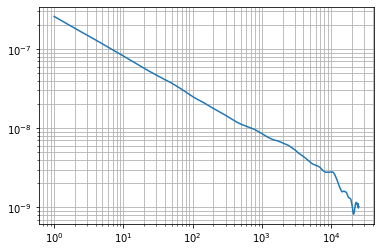

In [23]:
# what the std of the means of 100s with gaps of 10s:
U0 = 10

voltage = U0 + (brown+ white)*1.2
voltage = U0 + (white)*1.2


print(np.mean(voltage))
print(np.std(voltage)/U0)

(t2, ad, ade, adn) = at.oadev(voltage/U0, rate=rate, data_type="freq", taus=time)  # Compute the overlapping ADEV
plt.loglog(t2, ad, label='both')
plt.grid(which="both")

8.60394606864657e-08
6.026509103496552e-08
7.329532185515366e-08


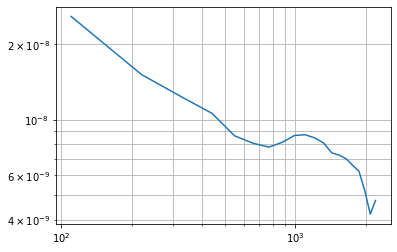

In [31]:
samples_time_range = 10
time_step = samples_time_range + 100
rate = 1/samples_time_range

means = []
time_array = np.arange(0, len(time), time_step)
for i in time_array:
    #print(i, i+samples_time_range)
    means.append(np.mean(voltage[i:i+samples_time_range]))

print(np.std(means)/U0)

means = np.asarray(means)
print(np.std(means[:6])/U0)

sep = means[1:] - means[:-1]
print(np.std(sep[:6])/U0)

(t2, ad, ade, adn) = at.oadev(means/U0, rate=rate, data_type="freq", taus=time_array)  # Compute the overlapping ADEV
plt.loglog(t2, ad, label='both')
plt.grid(which="both")


# 1) invariance theorem

What kind of stability is needed for the goal of reaching 2e-12 statistical uncertainty?

invariance is: nu_c = sqrt(nu_i^2) (implicit sum)

error budget is delnu_c/nu_c = sqrt((nu_i/nu_c^2 * delnu_i)^2)

In [32]:
ionA = "12C6+"
ionB = "20Ne10+"
ionC = "172Yb42+"
ionD = "176Yb42+"
B = 7 + brown

cycles = 5
these_voltages = -means

from fticr_toolkit import ideal_trap_physics as itp

print(len(these_voltages))
omm = itp.omegam_ionstr(ionD, these_voltages, B=B)
omm = np.array(omm, dtype=np.float64)

omz = itp.omegaz_ionstr(ionD, these_voltages)
omz = np.array(omz, dtype=np.float64)

print(np.mean(omz)/2/np.pi)
omp = itp.omegap_ionstr(ionD, these_voltages, B=B)
omp = np.array(omp, dtype=np.float64)

omc = itp.omegac_invariance(omm, omz, omp)
omc = np.array(omc, dtype=np.float64)


print(np.std(omc)/np.mean(omc))
print(np.std(omp)/np.mean(omp))
print(np.std(omp[:cycles])/np.mean(omp[:cycles]))
sep = omp[1:] - omp[:-1]
print(np.std(sep[:cycles])/np.mean(omp[:cycles]))
print(np.std(omz[:cycles])/np.mean(omz[:cycles]))
print(np.std(omz[:cycles])/2/np.pi)

455
417829.5431809415
1.9947472227949807e-16
1.1408001333627888e-11
8.72783213471772e-12
1.0631277616362745e-11
3.2912860323084346e-08
0.013751965152781482


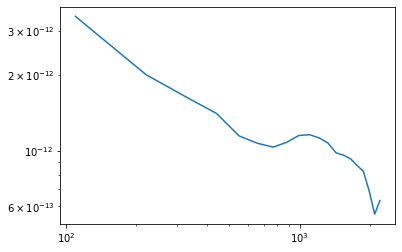

In [33]:


(t2, ad, ade, adn) = at.oadev(np.asarray(omp)/np.mean(omp), rate=rate, data_type="freq", taus=time_array)  # Compute the overlapping ADEV
plt.loglog(t2, ad, label='both')





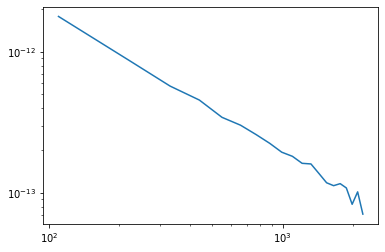

In [34]:


(t2, ad, ade, adn) = at.oadev(np.asarray(sep)/np.mean(omp), rate=rate, data_type="freq", taus=time_array)  # Compute the overlapping ADEV
plt.loglog(t2, ad, label='both')





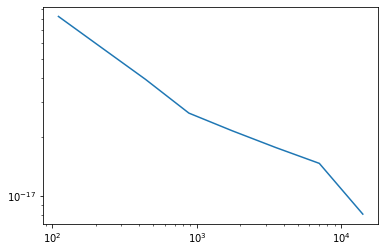

In [35]:

(t2, ad, ade, adn) = at.oadev(omc/np.mean(omc), rate=1/time_step, data_type="freq")
plt.loglog(t2, ad, label='domz/omz')
